In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

<hr>

### Read in the data

In [3]:
donations = pd.read_csv('../../data/processed_donations.csv')
donations.head()

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
0,00000ce845c00cbf0686c992fc369df4,2013-12-17 21:47:14,50.00,2013,12,17,21,47,14,evening,winter,4
1,00002783bc5d108510f3f9666c8b1edd,2016-02-02 18:34:27,99.00,2016,2,2,18,34,27,evening,winter,5
2,00002d44003ed46b066607c5455a999a,2016-10-25 20:15:11,10.00,2016,10,25,20,15,11,evening,fall,3
3,00002d44003ed46b066607c5455a999a,2017-01-16 01:11:20,15.51,2017,1,16,1,11,20,morning,winter,3
4,00002d44003ed46b066607c5455a999a,2017-01-16 14:20:10,100.00,2017,1,16,14,20,10,midday,winter,5


<hr>

## [Pandas GroupBy](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html)



The docs suggest 3 main parts to the groupby object.
1. How to access groups, and iteration
2. Ways to apply functions to groups
3. Available computations / stats that are supported by groupby objects

In [4]:
yearly_groupby = donations.groupby('year')

In [5]:
type(yearly_groupby)

pandas.core.groupby.generic.DataFrameGroupBy

<hr>

## Accessing groups

### By _Row Label_

In [6]:
yearly_groupby.groups

{2012: Int64Index([   2394,    9658,   27501,   42718,  127884,  195190,  238673,
              242388,  262075,  288576,
             ...
             4500186, 4501503, 4505021, 4515153, 4524712, 4528632, 4574890,
             4603253, 4630269, 4630270],
            dtype='int64', length=149),
 2013: Int64Index([      0,      25,      47,      51,      65,      66,      73,
                  77,      79,      81,
             ...
             4687831, 4687836, 4687837, 4687838, 4687840, 4687841, 4687842,
             4687843, 4687844, 4687849],
            dtype='int64', length=573983),
 2014: Int64Index([     26,      49,      52,      64,      67,      88,      89,
                  90,      91,      92,
             ...
             4687817, 4687818, 4687819, 4687833, 4687834, 4687855, 4687858,
             4687863, 4687869, 4687876],
            dtype='int64', length=746608),
 2015: Int64Index([     13,      23,      24,      53,      62,      68,      71,
                  72,   

### By _Row Index_

In [7]:
yearly_groupby.indices

{2012: array([   2394,    9658,   27501,   42718,  127884,  195190,  238673,
         242388,  262075,  288576,  306068,  364234,  452688,  456090,
         501583,  510010,  517685,  571738,  574056,  640625,  741789,
         823228,  862224,  876752,  878599,  887197,  928190,  934257,
         973280,  983148,  988227,  995162, 1046060, 1053581, 1181749,
        1286557, 1294184, 1308536, 1383554, 1400718, 1458240, 1458241,
        1458242, 1458243, 1458244, 1551440, 1563169, 1617615, 1652478,
        1748397, 1777476, 1874450, 1976899, 2000110, 2025772, 2035914,
        2035915, 2051956, 2090277, 2201367, 2241758, 2245790, 2271860,
        2274079, 2285235, 2299902, 2320269, 2407526, 2454917, 2468209,
        2468599, 2473785, 2546716, 2619486, 2639890, 2639891, 2644883,
        2755535, 2772687, 2785525, 2800739, 2829279, 2840834, 2867166,
        2874092, 2908956, 2926550, 2935562, 2958685, 2977042, 3003753,
        3008205, 3046759, 3067679, 3083558, 3100542, 3204221, 3208938,


Just a dict! 
This makes it really easy to select specific groups individually.

In [8]:
type(yearly_groupby.groups)

dict

In [9]:
yearly_groupby.groups[2012]

Int64Index([   2394,    9658,   27501,   42718,  127884,  195190,  238673,
             242388,  262075,  288576,
            ...
            4500186, 4501503, 4505021, 4515153, 4524712, 4528632, 4574890,
            4603253, 4630269, 4630270],
           dtype='int64', length=149)

Let's look at the year of 2012.
We know that we can select rows based on Index (label or value).. 
So, we should be able to use `.loc` to reference all the rows from the 2012 group.

### Accessing group from original dataframe

In [10]:
# query for rows in the 2012 group, and give me all the columns
donations.loc[yearly_groupby.groups[2012], :]

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
2394,0022377355fee1df711808380ecb6636,2012-12-18 03:24:46,25.0,2012,12,18,3,24,46,morning,winter,4
9658,0098662055b3a3bd5c5ea73a9cd582d8,2012-12-18 10:33:27,25.0,2012,12,18,10,33,27,morning,winter,4
27501,017609b5267136960039208425531d0a,2012-12-05 22:04:05,25.0,2012,12,5,22,4,5,evening,winter,4
42718,02617d62e0133ba9cc81a0abc34d4f0d,2012-12-14 13:02:06,20.0,2012,12,14,13,2,6,midday,winter,3
127884,0743b3fcf36a9287bd01a759c0dca224,2012-11-04 16:30:37,150.0,2012,11,4,16,30,37,midday,fall,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4528632,f76e17bd254ffb1bf6a4dcb1698c85dc,2012-11-10 00:49:47,10.0,2012,11,10,0,49,47,morning,fall,3
4574890,f9f9312786079a621fec74f35ea75606,2012-10-10 22:24:21,20.0,2012,10,10,22,24,21,evening,fall,3
4603253,fb89b09d08de982284eb5177ab00fcf3,2012-10-14 13:38:29,50.0,2012,10,14,13,38,29,midday,fall,4
4630269,fcf96e729bf1b03dfbd8f07a3b4ee173,2012-10-08 13:53:00,25.0,2012,10,8,13,53,0,midday,fall,4


In [11]:
yearly_groupby.get_group(2012)

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
2394,0022377355fee1df711808380ecb6636,2012-12-18 03:24:46,25.0,2012,12,18,3,24,46,morning,winter,4
9658,0098662055b3a3bd5c5ea73a9cd582d8,2012-12-18 10:33:27,25.0,2012,12,18,10,33,27,morning,winter,4
27501,017609b5267136960039208425531d0a,2012-12-05 22:04:05,25.0,2012,12,5,22,4,5,evening,winter,4
42718,02617d62e0133ba9cc81a0abc34d4f0d,2012-12-14 13:02:06,20.0,2012,12,14,13,2,6,midday,winter,3
127884,0743b3fcf36a9287bd01a759c0dca224,2012-11-04 16:30:37,150.0,2012,11,4,16,30,37,midday,fall,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4528632,f76e17bd254ffb1bf6a4dcb1698c85dc,2012-11-10 00:49:47,10.0,2012,11,10,0,49,47,morning,fall,3
4574890,f9f9312786079a621fec74f35ea75606,2012-10-10 22:24:21,20.0,2012,10,10,22,24,21,evening,fall,3
4603253,fb89b09d08de982284eb5177ab00fcf3,2012-10-14 13:38:29,50.0,2012,10,14,13,38,29,midday,fall,4
4630269,fcf96e729bf1b03dfbd8f07a3b4ee173,2012-10-08 13:53:00,25.0,2012,10,8,13,53,0,midday,fall,4


### Accessing multiple groups..

In [14]:
df_2012 = yearly_groupby.get_group(2012)
df_2013 = yearly_groupby.get_group(2013)

pd.concat([df_2012, df_2013])

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
2394,0022377355fee1df711808380ecb6636,2012-12-18 03:24:46,25.0,2012,12,18,3,24,46,morning,winter,4
9658,0098662055b3a3bd5c5ea73a9cd582d8,2012-12-18 10:33:27,25.0,2012,12,18,10,33,27,morning,winter,4
27501,017609b5267136960039208425531d0a,2012-12-05 22:04:05,25.0,2012,12,5,22,4,5,evening,winter,4
42718,02617d62e0133ba9cc81a0abc34d4f0d,2012-12-14 13:02:06,20.0,2012,12,14,13,2,6,midday,winter,3
127884,0743b3fcf36a9287bd01a759c0dca224,2012-11-04 16:30:37,150.0,2012,11,4,16,30,37,midday,fall,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4687841,fffed4187f3b5f17cb58536f7fac8dee,2013-11-20 14:23:08,10.0,2013,11,20,14,23,8,midday,fall,3
4687842,fffed4187f3b5f17cb58536f7fac8dee,2013-11-20 14:23:09,11.0,2013,11,20,14,23,9,midday,fall,3
4687843,fffed4187f3b5f17cb58536f7fac8dee,2013-12-08 20:40:46,1.0,2013,12,8,20,40,46,evening,winter,1
4687844,fffed4187f3b5f17cb58536f7fac8dee,2013-12-08 21:40:03,5.0,2013,12,8,21,40,3,evening,winter,2


In [12]:
# add the sets of indices together into one list
group_2012_2013 = np.concatenate((
    yearly_groupby.groups[2012], 
    yearly_groupby.groups[2013]), 
    axis=None)

donations.loc[group_2012_2013, :]

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
2394,0022377355fee1df711808380ecb6636,2012-12-18 03:24:46,25.0,2012,12,18,3,24,46,morning,winter,4
9658,0098662055b3a3bd5c5ea73a9cd582d8,2012-12-18 10:33:27,25.0,2012,12,18,10,33,27,morning,winter,4
27501,017609b5267136960039208425531d0a,2012-12-05 22:04:05,25.0,2012,12,5,22,4,5,evening,winter,4
42718,02617d62e0133ba9cc81a0abc34d4f0d,2012-12-14 13:02:06,20.0,2012,12,14,13,2,6,midday,winter,3
127884,0743b3fcf36a9287bd01a759c0dca224,2012-11-04 16:30:37,150.0,2012,11,4,16,30,37,midday,fall,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4687841,fffed4187f3b5f17cb58536f7fac8dee,2013-11-20 14:23:08,10.0,2013,11,20,14,23,8,midday,fall,3
4687842,fffed4187f3b5f17cb58536f7fac8dee,2013-11-20 14:23:09,11.0,2013,11,20,14,23,9,midday,fall,3
4687843,fffed4187f3b5f17cb58536f7fac8dee,2013-12-08 20:40:46,1.0,2013,12,8,20,40,46,evening,winter,1
4687844,fffed4187f3b5f17cb58536f7fac8dee,2013-12-08 21:40:03,5.0,2013,12,8,21,40,3,evening,winter,2


<hr>

## Iteration
What if we wanted to perform the same operation over all the groups?

```
GroupBy.__iter__::
    Generator yielding sequence of (name, subsetted object)
```

In [15]:
for name, subsetted_object in yearly_groupby:
    print(name)
    print(f'Name type: {type(name)}')

2012
Name type: <class 'int'>
2013
Name type: <class 'int'>
2014
Name type: <class 'int'>
2015
Name type: <class 'int'>
2016
Name type: <class 'int'>
2017
Name type: <class 'int'>
2018
Name type: <class 'int'>


In [16]:
for name, subsetted_object in yearly_groupby:
    print(subsetted_object.shape)
    print(f'subsetted object type: {type(subsetted_object)}')

(149, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(573983, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(746608, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(783362, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(957265, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(1190542, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>
(435975, 12)
subsetted object type: <class 'pandas.core.frame.DataFrame'>


<hr>

## Ok, what about computations?

### Basic [computations / stats](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html#computations-descriptive-stats)

In [17]:
# notice how all of the columns are some sort of numeric type.. Where is ID?
yearly_groupby.sum()

,amount,month,day,hour,minute,second,category
year,,,,,,,
2012,2.484264e+04,1632,2235,2226,4483,4173,607
2013,3.042822e+07,4488531,9003882,8260199,16891508,16273206,2021675
2014,4.146127e+07,5275234,12067613,10805452,22062381,21856259,2687857
2015,5.048835e+07,5518209,12548189,11378522,23203709,23139142,3010542
2016,6.265223e+07,6911138,15812502,13830451,28303204,28244406,3755617
2017,7.287213e+07,8198245,19940024,17096514,35220301,35083109,4565112
2018,2.648120e+07,1148525,6789414,6205495,12840678,12851808,1674289


In [18]:
# on a single column --> Returns a (named) series!
yearly_groupby.amount.sum()

year
2012    2.484264e+04
2013    3.042822e+07
2014    4.146127e+07
2015    5.048835e+07
2016    6.265223e+07
2017    7.287213e+07
2018    2.648120e+07
Name: amount, dtype: float64

In [19]:
type(yearly_groupby.amount.sum())

pandas.core.series.Series

In [20]:
# specified columns --> Returns a dataframe!
yearly_groupby[['amount', 'second']].sum()

,amount,second
year,,
2012,2.484264e+04,4173
2013,3.042822e+07,16273206
2014,4.146127e+07,21856259
2015,5.048835e+07,23139142
2016,6.265223e+07,28244406
2017,7.287213e+07,35083109
2018,2.648120e+07,12851808


In [21]:
type(yearly_groupby[['amount', 'second']].sum())

pandas.core.frame.DataFrame

Are there other ways to write this? Yep

### All the ways to do the same thing..

In [22]:
yearly_groupby.amount.apply(np.sum)

year
2012       24842.64
2013    30428220.80
2014    41461266.85
2015    50488354.49
2016    62652231.24
2017    72872130.78
2018    26481196.48
Name: amount, dtype: float64

In [23]:
yearly_groupby.amount.agg(np.sum)

year
2012    2.484264e+04
2013    3.042822e+07
2014    4.146127e+07
2015    5.048835e+07
2016    6.265223e+07
2017    7.287213e+07
2018    2.648120e+07
Name: amount, dtype: float64

In [24]:
yearly_groupby.amount.agg(summed_amount=np.sum)

,summed_amount
year,
2012,2.484264e+04
2013,3.042822e+07
2014,4.146127e+07
2015,5.048835e+07
2016,6.265223e+07
2017,7.287213e+07
2018,2.648120e+07


In [25]:
yearly_groupby.amount.aggregate(np.sum)

year
2012    2.484264e+04
2013    3.042822e+07
2014    4.146127e+07
2015    5.048835e+07
2016    6.265223e+07
2017    7.287213e+07
2018    2.648120e+07
Name: amount, dtype: float64

In [26]:
yearly_groupby.amount.pipe(np.sum)

year
2012       24842.64
2013    30428220.80
2014    41461266.85
2015    50488354.49
2016    62652231.24
2017    72872130.78
2018    26481196.48
Name: amount, dtype: float64

Great!!
Now we know 5 ways to do the same thing.
What is the use of that??

*Why use one over another*:

* `Groupby.<function>()` -- Use for a short win! This is great if you already have a column selected, and you only want to do a single computation, and you don't care about the name.
    
* `GroupBy.agg(..)` -- This is my favorite overall. You know what to expect, you can specify names, and perform multiple operations all in one go. 

* `GroupBy.apply(func)` -- Create your own function to use as an aggregation! It must take the grouped dataframe as an argument, and return a similar type (dataframe, series). Pandas will know how to join it back together. However, it's slow.

* `GroupBy.pipe(..)[.pipe(..)]` -- This is great when you want to "pipe (or chain)" multiple aggregations together. Maybe a second aggregation is based off the first, so you need to reference it after the fact.

In my opinion.. Erase the remainder from your mind.

### More complex examples

In [27]:
donations.head()

,id,created_at,amount,year,month,day,hour,minute,second,time_of_the_day,season,category
0,00000ce845c00cbf0686c992fc369df4,2013-12-17 21:47:14,50.00,2013,12,17,21,47,14,evening,winter,4
1,00002783bc5d108510f3f9666c8b1edd,2016-02-02 18:34:27,99.00,2016,2,2,18,34,27,evening,winter,5
2,00002d44003ed46b066607c5455a999a,2016-10-25 20:15:11,10.00,2016,10,25,20,15,11,evening,fall,3
3,00002d44003ed46b066607c5455a999a,2017-01-16 01:11:20,15.51,2017,1,16,1,11,20,morning,winter,3
4,00002d44003ed46b066607c5455a999a,2017-01-16 14:20:10,100.00,2017,1,16,14,20,10,midday,winter,5


In [28]:
yearly_aggs = yearly_groupby.agg(
    {
        'id': {
            'nunique': 'nunique'
        },
        'month': {
            'most_common': lambda x: x.value_counts().index[0],
            'most_uncommon': lambda x: x.value_counts().index[-1],
        },
        'day': {
            'most_common': lambda x: x.value_counts().index[0],
            'most_uncommon': lambda x: x.value_counts().index[-1],
        }
    }
)

/Users/ntistp30/.virtualenvs/da1_python_clinic-qBEK-8wr/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [29]:
yearly_aggs

id       month                       day              
     nunique most_common most_uncommon most_common most_uncommon
year                                                            
2012     141          10            11          14             1
2013  320102           9             1           5            31
2014  382817           8             6          23            31
2015  446048           8             6          21            31
2016  555843           8             6          29            31
2017  574599           8             4          28            31
2018  230433           1             5          25            31

Draw histograms of the results..

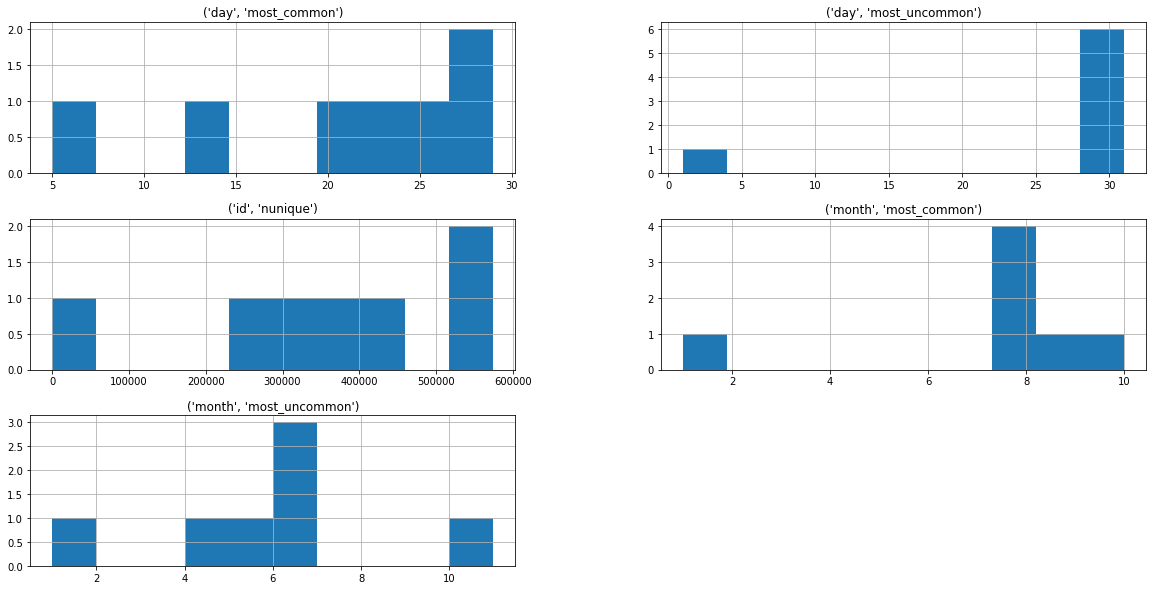

In [30]:
yearly_aggs.hist(figsize=(20, 10));

<hr>

### Fix the MultiIndex

In [31]:
yearly_aggs.columns

MultiIndex([(   'id',       'nunique'),
            ('month',   'most_common'),
            ('month', 'most_uncommon'),
            (  'day',   'most_common'),
            (  'day', 'most_uncommon')],
           )

In [32]:
yearly_aggs.columns = [f'{agg}__{col}' for col, agg in yearly_aggs.columns]
yearly_aggs.columns

Index(['nunique__id', 'most_common__month', 'most_uncommon__month',
       'most_common__day', 'most_uncommon__day'],
      dtype='object')

Convert to a normal dataframe..

In [33]:
yearly_aggs.reset_index()

,year,nunique__id,most_common__month,most_uncommon__month,most_common__day,most_uncommon__day
0,2012,141,10,11,14,1
1,2013,320102,9,1,5,31
2,2014,382817,8,6,23,31
3,2015,446048,8,6,21,31
4,2016,555843,8,6,29,31
5,2017,574599,8,4,28,31
6,2018,230433,1,5,25,31
